In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Data Preparation

In [1]:
import os
import random
from PIL import Image

os.mkdir("./train_images")    
os.mkdir("./test_images")

source = "./Dental"

for file in os.listdir(source):
    
    images = os.listdir(os.path.join(source, file))
    n_images = len(images)
    if n_images < 15 : 
        continue
        
    size_test = int(0.1*n_images)
    test_images = random.sample(images, size_test)
    train_images = images.copy()
    for image in test_images:
        train_images.remove(image)
        
    os.mkdir(os.path.join("./train_images", file))
    os.mkdir(os.path.join("./test_images", file))
    

    for image in train_images:
        im = Image.open(os.path.join(source, file, image))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join("./train_images", file, image))
        
    for image in test_images:
        im = Image.open(os.path.join(source, file, image))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join("./test_images", file, image))
        

In [3]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
# choose the training and test datasets
train_data = datasets.ImageFolder("./train_images",
                                  transform=train_transforms)
test_data = datasets.ImageFolder("./test_images",
                                 transform=test_transforms)
classes = train_data.classes
# obtain training indices that will be used for validation
validation_ratio = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_ratio * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders_scratch = {'train': train_loader, 'valid': valid_loader,
                   'test': test_loader}

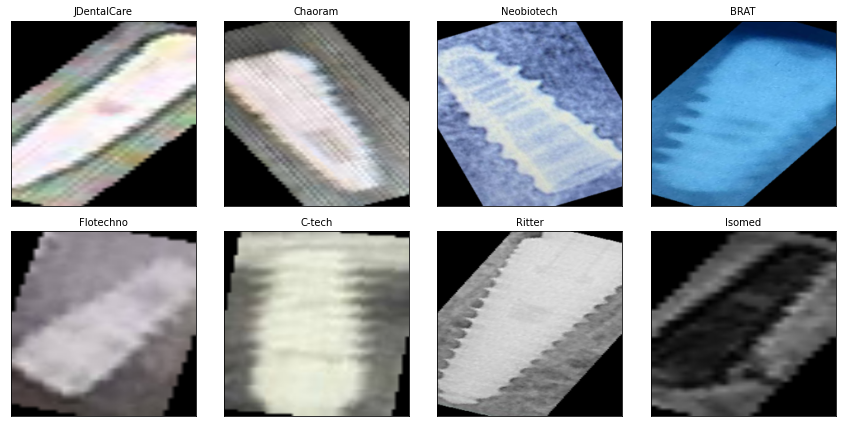

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
images, labels = iter(loaders_scratch["train"]).next()
images = images.numpy() 

# plot images from the batch, along with the corresponding labels
fig = plt.figure(figsize=(12, 6))
for idx in np.arange(8):
    img = images[idx] / 2 + 0.5  # unnormalize
    label = labels[idx]
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(classes[label], fontsize = 10)
fig.tight_layout()

# Model Definition

## 1 - Using Custom Model

In [4]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return optim.Adam(model.parameters(), lr=0.001)    

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)   
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)  
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)  


        self.linear1 = nn.Linear(25088, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 27)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.3)
        
    
    def forward(self, x):
    
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        #print(x.size())
        
        x = x.view(-1, 25088)
        
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.relu(self.linear2(x))
        x = self.drop(x)

        x = self.linear3(x)
        
        return x

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        counter = 0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss =  criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            counter += 1
            
        train_loss = train_loss / counter
        torch.cuda.empty_cache()
        
        ######################    
        # validate the model #
        ######################
        counter = 0
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):

                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                    
                output = model(data)
                loss =  criterion(output, target)
                valid_loss += loss.item()
                output = F.softmax(output, dim = 1)
                _, pred = torch.max(output, 1)    
                correct_tensor = pred.eq(target.data.view_as(pred)).int()
                valid_acc += torch.mean(correct_tensor.type(torch.FloatTensor))
                counter += 1
                
            valid_acc = (valid_acc / counter) * 100
            valid_loss = valid_loss / counter
            
        torch.cuda.empty_cache()
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}%'.format(
        epoch, train_loss, valid_loss, valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

## Experiment with Defualt Weight Initialization

In [18]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100
    
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_defualt_weight.pt')

Epoch: 1 	Training Loss: 3.179534 	Validation Loss: 2.996463 	Validation Accuracy: 14.444%
Validation loss decreased (inf --> 2.996463).  Saving model ...
Epoch: 2 	Training Loss: 3.078262 	Validation Loss: 3.039112 	Validation Accuracy: 14.444%
Epoch: 3 	Training Loss: 3.043496 	Validation Loss: 2.946864 	Validation Accuracy: 14.444%
Validation loss decreased (2.996463 --> 2.946864).  Saving model ...
Epoch: 4 	Training Loss: 2.982592 	Validation Loss: 2.887792 	Validation Accuracy: 15.556%
Validation loss decreased (2.946864 --> 2.887792).  Saving model ...
Epoch: 5 	Training Loss: 2.943817 	Validation Loss: 2.888672 	Validation Accuracy: 17.222%
Epoch: 6 	Training Loss: 2.904961 	Validation Loss: 2.887118 	Validation Accuracy: 15.556%
Validation loss decreased (2.887792 --> 2.887118).  Saving model ...
Epoch: 7 	Training Loss: 2.846474 	Validation Loss: 2.928192 	Validation Accuracy: 13.333%
Epoch: 8 	Training Loss: 2.789952 	Validation Loss: 2.836128 	Validation Accuracy: 21.667%
V

Epoch: 76 	Training Loss: 0.375214 	Validation Loss: 2.544851 	Validation Accuracy: 55.000%
Epoch: 77 	Training Loss: 0.407280 	Validation Loss: 2.611108 	Validation Accuracy: 52.778%
Epoch: 78 	Training Loss: 0.360142 	Validation Loss: 2.469512 	Validation Accuracy: 55.556%
Epoch: 79 	Training Loss: 0.334585 	Validation Loss: 2.862764 	Validation Accuracy: 55.000%
Epoch: 80 	Training Loss: 0.457562 	Validation Loss: 2.584434 	Validation Accuracy: 56.111%
Epoch: 81 	Training Loss: 0.351380 	Validation Loss: 2.474931 	Validation Accuracy: 56.111%
Epoch: 82 	Training Loss: 0.316153 	Validation Loss: 2.695678 	Validation Accuracy: 61.111%
Epoch: 83 	Training Loss: 0.320683 	Validation Loss: 2.790262 	Validation Accuracy: 53.889%
Epoch: 84 	Training Loss: 0.362153 	Validation Loss: 2.818209 	Validation Accuracy: 51.111%
Epoch: 85 	Training Loss: 0.423313 	Validation Loss: 2.150338 	Validation Accuracy: 56.111%
Epoch: 86 	Training Loss: 0.324169 	Validation Loss: 2.857594 	Validation Accura

## Experiment with Custom Weight Initialization

In [16]:
import math

def custom_weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.normal_(0, y)
    elif classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        y = math.sqrt(2. / n)
        m.weight.data.normal_(0, y)

In [16]:
# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
model_scratch.apply(custom_weight_init)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=25088, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=27, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.3, inplace=False)
)

In [17]:
model_scratch = train(100, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_custom_weight.pt')

Epoch: 1 	Training Loss: 3.239950 	Validation Loss: 2.980911 	Validation Accuracy: 14.444%
Validation loss decreased (inf --> 2.980911).  Saving model ...
Epoch: 2 	Training Loss: 3.087328 	Validation Loss: 3.221045 	Validation Accuracy: 14.444%
Epoch: 3 	Training Loss: 3.025153 	Validation Loss: 2.933979 	Validation Accuracy: 16.111%
Validation loss decreased (2.980911 --> 2.933979).  Saving model ...
Epoch: 4 	Training Loss: 2.988007 	Validation Loss: 2.863873 	Validation Accuracy: 16.667%
Validation loss decreased (2.933979 --> 2.863873).  Saving model ...
Epoch: 5 	Training Loss: 2.931668 	Validation Loss: 2.809675 	Validation Accuracy: 15.556%
Validation loss decreased (2.863873 --> 2.809675).  Saving model ...
Epoch: 6 	Training Loss: 2.891933 	Validation Loss: 2.806387 	Validation Accuracy: 16.667%
Validation loss decreased (2.809675 --> 2.806387).  Saving model ...
Epoch: 7 	Training Loss: 2.887247 	Validation Loss: 2.890288 	Validation Accuracy: 17.222%
Epoch: 8 	Training Loss

Epoch: 80 	Training Loss: 0.300281 	Validation Loss: 2.991372 	Validation Accuracy: 55.000%
Epoch: 81 	Training Loss: 0.263328 	Validation Loss: 2.934946 	Validation Accuracy: 57.222%
Epoch: 82 	Training Loss: 0.422338 	Validation Loss: 2.584538 	Validation Accuracy: 56.667%
Epoch: 83 	Training Loss: 0.331683 	Validation Loss: 2.684309 	Validation Accuracy: 61.111%
Epoch: 84 	Training Loss: 0.381046 	Validation Loss: 2.996730 	Validation Accuracy: 53.889%
Epoch: 85 	Training Loss: 0.469951 	Validation Loss: 3.167499 	Validation Accuracy: 58.333%
Epoch: 86 	Training Loss: 0.294630 	Validation Loss: 2.576796 	Validation Accuracy: 60.000%
Epoch: 87 	Training Loss: 0.309553 	Validation Loss: 2.933070 	Validation Accuracy: 58.333%
Epoch: 88 	Training Loss: 0.248163 	Validation Loss: 2.978995 	Validation Accuracy: 57.222%
Epoch: 89 	Training Loss: 0.309644 	Validation Loss: 2.941157 	Validation Accuracy: 58.333%
Epoch: 90 	Training Loss: 0.275520 	Validation Loss: 2.816778 	Validation Accura

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [10]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_defualt_weight.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.902463


Test Accuracy: 55% (48/86)


## 2 - Using Transfer Learning

In [8]:
from torchvision import models

In [9]:
model_transfer =  models.vgg16(pretrained=True)

In [10]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
out_input = model_transfer.classifier[6].out_features

model_transfer.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(out_input, len(classes))
)

In [12]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [13]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
model_transfer.classifier.apply(custom_weight_init)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=1000, out_features=46, bias=True)
)

In [18]:
if use_cuda:
    model_transfer = model_transfer.cuda()

In [19]:
loaders_transfer = loaders_scratch.copy()

In [20]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss() 


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    # more general solution:
    # filter(lambda param: param.requires_grad, model_transfer.parameters())
    return optimizer

In [16]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
    
model_transfer = train(200, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 3.606157 	Validation Loss: 3.249925 	Validation Accuracy: 17.788%
Validation loss decreased (inf --> 3.249925).  Saving model ...
Epoch: 2 	Training Loss: 3.180889 	Validation Loss: 3.189976 	Validation Accuracy: 18.429%
Validation loss decreased (3.249925 --> 3.189976).  Saving model ...
Epoch: 3 	Training Loss: 3.024702 	Validation Loss: 2.951819 	Validation Accuracy: 22.917%
Validation loss decreased (3.189976 --> 2.951819).  Saving model ...
Epoch: 4 	Training Loss: 2.940317 	Validation Loss: 2.803417 	Validation Accuracy: 27.484%
Validation loss decreased (2.951819 --> 2.803417).  Saving model ...
Epoch: 5 	Training Loss: 2.787658 	Validation Loss: 2.829367 	Validation Accuracy: 25.641%
Epoch: 6 	Training Loss: 2.692467 	Validation Loss: 2.690802 	Validation Accuracy: 29.888%
Validation loss decreased (2.803417 --> 2.690802).  Saving model ...
Epoch: 7 	Training Loss: 2.667925 	Validation Loss: 2.680482 	Validation Accuracy: 31.010%
Validation loss decreas

Epoch: 70 	Training Loss: 0.895486 	Validation Loss: 1.863750 	Validation Accuracy: 54.888%
Epoch: 71 	Training Loss: 0.868803 	Validation Loss: 1.877142 	Validation Accuracy: 56.571%
Epoch: 72 	Training Loss: 0.907757 	Validation Loss: 1.928441 	Validation Accuracy: 53.365%
Epoch: 73 	Training Loss: 0.899730 	Validation Loss: 1.795768 	Validation Accuracy: 57.933%
Epoch: 74 	Training Loss: 0.958183 	Validation Loss: 1.939787 	Validation Accuracy: 52.404%
Epoch: 75 	Training Loss: 0.934105 	Validation Loss: 1.750415 	Validation Accuracy: 55.929%
Epoch: 76 	Training Loss: 0.885278 	Validation Loss: 1.893034 	Validation Accuracy: 55.128%
Epoch: 77 	Training Loss: 0.837439 	Validation Loss: 1.671274 	Validation Accuracy: 57.853%
Validation loss decreased (1.729653 --> 1.671274).  Saving model ...
Epoch: 78 	Training Loss: 0.850457 	Validation Loss: 1.868400 	Validation Accuracy: 55.769%
Epoch: 79 	Training Loss: 0.853502 	Validation Loss: 1.795119 	Validation Accuracy: 58.093%
Epoch: 80 	

Epoch: 157 	Training Loss: 0.443093 	Validation Loss: 1.760954 	Validation Accuracy: 62.420%
Epoch: 158 	Training Loss: 0.477178 	Validation Loss: 1.771860 	Validation Accuracy: 63.622%
Epoch: 159 	Training Loss: 0.454614 	Validation Loss: 1.801414 	Validation Accuracy: 62.420%
Epoch: 160 	Training Loss: 0.484364 	Validation Loss: 1.694612 	Validation Accuracy: 65.785%
Epoch: 161 	Training Loss: 0.477160 	Validation Loss: 1.762251 	Validation Accuracy: 61.779%
Epoch: 162 	Training Loss: 0.466782 	Validation Loss: 1.690579 	Validation Accuracy: 62.580%
Epoch: 163 	Training Loss: 0.460188 	Validation Loss: 1.767844 	Validation Accuracy: 61.699%
Epoch: 164 	Training Loss: 0.442037 	Validation Loss: 1.914056 	Validation Accuracy: 58.654%
Epoch: 165 	Training Loss: 0.454102 	Validation Loss: 1.755658 	Validation Accuracy: 63.622%
Epoch: 166 	Training Loss: 0.437179 	Validation Loss: 1.665903 	Validation Accuracy: 66.106%
Epoch: 167 	Training Loss: 0.405293 	Validation Loss: 1.746028 	Valida

In [17]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.914707


Test Accuracy: 65% (134/206)


# ----------------------

In [23]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.658585


Test Accuracy: 84% (175/206)


In [24]:
from PIL import Image

def test_on_image(model, image_url):
    image = Image.open(image_url).convert('RGB')
    display(image)
    classes = train_data.classes
    data = test_transforms(image)
    data = data[None, :]
    if use_cuda:
            data = data.cuda()
    model.eval()
    output = model(data)
    output = F.softmax(output, dim = 1)
    prob, index = torch.topk(output, 10)
    prob = torch.squeeze(prob)
    index = torch.squeeze(index)
    
    for i in range(len(prob)):
        print(classes[index[i].item()], " -> ", round(prob[i].item() * 100, 2), "%")

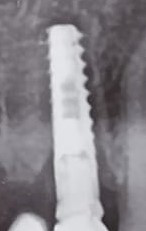

Argon  ->  98.08 %
Bilimplant  ->  0.87 %
Blue Sky Bio  ->  0.32 %
General  ->  0.19 %
Dentium  ->  0.17 %
Vitronex  ->  0.16 %
BTK  ->  0.06 %
Medisolaris  ->  0.04 %
BioInfinity Implant  ->  0.03 %
TUT  ->  0.02 %


In [25]:
test_on_image(model_transfer, "./1.jpg")